In [242]:
#Transfer Learnign Model Keras

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras import backend as K
from keras.optimizers import Adam
import numpy as np


In [243]:
img_width, img_height = 224, 224

#top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = '/home/ec2-user/src/Data/ChestXray/chest_xray/train'
validation_data_dir = '/home/ec2-user/src/Data/ChestXray/chest_xray/val'
test_dir = '/home/ec2-user/src/Data/ChestXray/chest_xray/test'
nb_train_samples = 5216
nb_validation_samples = 16
epochs = 100
batch_size = 16
nb_test_samples = 624
test_batch_size = 16


In [244]:
model = applications.VGG16(include_top=False, weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [245]:
# reading in image data from training and validation steps 

# use ImageDataGenerator to normalize/augment 

datagen = ImageDataGenerator(rescale=1. / 255)

# use flow_from_directory method to resize/pre-process 

generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

#use model predict to create bottleneck weights from VGG16 & save to .npy file

bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
np.save(open('bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
np.save(open('bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

generator = datagen.flow_from_directory(
        test_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

bottleneck_features_test = model.predict_generator(
        generator, nb_test_samples // batch_size)
np.save(open('bottleneck_features_test.npy', 'wb'), bottleneck_features_test)



Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [246]:
# train and create labels in sequential order

# Normal 0; Pneumonia 1 

train_data = np.load(open('bottleneck_features_train.npy','rb'))
train_labels = np.array([0] * (1341) + [1] * (3875))

validation_data = np.load(open('bottleneck_features_validation.npy','rb'))
validation_labels = np.array([0] * (8) + [1] * (8))

test_data = np.load(open('bottleneck_features_test.npy','rb'))
test_labels = np.array([0] * (234) + [1] * (390))



In [247]:
print(train_data.shape)
print(train_labels.shape)
print(validation_data.shape)
print(validation_labels.shape)

print(test_data.shape)
print(test_labels.shape)

(5216, 7, 7, 512)
(5216,)
(16, 7, 7, 512)
(16,)
(624, 7, 7, 512)
(624,)


In [248]:
# create dense fully connected model to add to base pre-configured model 
# inputs from trained bottled features

model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))
model.summary()

adam = Adam(lr=0.0001, decay=0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_25 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_69 (Dense)             (None, 500)               12544500  
_________________________________________________________________
dropout_45 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 250)               125250    
_________________________________________________________________
dropout_46 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 251       
Total params: 12,670,001
Trainable params: 12,670,001
Non-trainable params: 0
________________________________________________________________

In [249]:
# fit combined models to data

from keras.callbacks import ModelCheckpoint   

# train the model
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

predict = model.fit(train_data, train_labels,
             epochs=epochs,
             batch_size=batch_size,
             validation_data=(validation_data, validation_labels), callbacks=[checkpointer], verbose =1)


Train on 5216 samples, validate on 16 samples
Epoch 1/100
5216/5216 [==============================] - 9s - loss: 0.2531 - acc: 0.8928 - val_loss: 0.4293 - val_acc: 0.7500
Epoch 2/100
5216/5216 [==============================] - 6s - loss: 0.1120 - acc: 0.9595 - val_loss: 0.7281 - val_acc: 0.6875
Epoch 3/100
5216/5216 [==============================] - 7s - loss: 0.0936 - acc: 0.9682 - val_loss: 0.4202 - val_acc: 0.7500
Epoch 4/100
5216/5216 [==============================] - 6s - loss: 0.0809 - acc: 0.9714 - val_loss: 0.4227 - val_acc: 0.8750
Epoch 5/100
5216/5216 [==============================] - 7s - loss: 0.0645 - acc: 0.9753 - val_loss: 0.3437 - val_acc: 0.8750
Epoch 6/100
5216/5216 [==============================] - 6s - loss: 0.0590 - acc: 0.9795 - val_loss: 0.8151 - val_acc: 0.6875
Epoch 7/100
5216/5216 [==============================] - 7s - loss: 0.0511 - acc: 0.9808 - val_loss: 0.3278 - val_acc: 0.8750
Epoch 8/100
5216/5216 [==============================] - 7s - loss: 0.05

5216/5216 [==============================] - 7s - loss: 0.0076 - acc: 0.9975 - val_loss: 0.0317 - val_acc: 1.0000
Epoch 33/100
5216/5216 [==============================] - 6s - loss: 0.0074 - acc: 0.9981 - val_loss: 0.0623 - val_acc: 1.0000
Epoch 34/100
5216/5216 [==============================] - 6s - loss: 0.0058 - acc: 0.9979 - val_loss: 0.1676 - val_acc: 0.8750
Epoch 35/100
5216/5216 [==============================] - 6s - loss: 0.0035 - acc: 0.9988 - val_loss: 0.2112 - val_acc: 0.8750
Epoch 36/100
5216/5216 [==============================] - 6s - loss: 0.0103 - acc: 0.9967 - val_loss: 0.2986 - val_acc: 0.8750
Epoch 37/100
5216/5216 [==============================] - 6s - loss: 0.0056 - acc: 0.9983 - val_loss: 0.0734 - val_acc: 0.9375
Epoch 38/100
5216/5216 [==============================] - 6s - loss: 0.0082 - acc: 0.9969 - val_loss: 0.1699 - val_acc: 0.8750
Epoch 39/100
5216/5216 [==============================] - 6s - loss: 0.0044 - acc: 0.9987 - val_loss: 0.1633 - val_acc: 0.87

5216/5216 [==============================] - 6s - loss: 0.0011 - acc: 0.9998 - val_loss: 0.7466 - val_acc: 0.8750
Epoch 66/100
5216/5216 [==============================] - 7s - loss: 9.2758e-04 - acc: 0.9998 - val_loss: 0.0212 - val_acc: 1.0000
Epoch 67/100
5216/5216 [==============================] - 6s - loss: 0.0043 - acc: 0.9983 - val_loss: 0.3574 - val_acc: 0.8750
Epoch 68/100
5216/5216 [==============================] - 6s - loss: 0.0014 - acc: 0.9998 - val_loss: 0.5709 - val_acc: 0.8750
Epoch 69/100
5216/5216 [==============================] - 6s - loss: 0.0026 - acc: 0.9990 - val_loss: 0.1028 - val_acc: 0.9375
Epoch 70/100
5216/5216 [==============================] - 6s - loss: 0.0020 - acc: 0.9992 - val_loss: 0.8234 - val_acc: 0.8750
Epoch 71/100
5216/5216 [==============================] - 6s - loss: 0.0028 - acc: 0.9990 - val_loss: 0.2135 - val_acc: 0.8750
Epoch 72/100
5216/5216 [==============================] - 6s - loss: 0.0020 - acc: 0.9994 - val_loss: 0.0703 - val_acc: 

5216/5216 [==============================] - 6s - loss: 3.6042e-04 - acc: 0.9998 - val_loss: 0.3835 - val_acc: 0.8750
Epoch 99/100
5216/5216 [==============================] - 6s - loss: 1.5232e-04 - acc: 1.0000 - val_loss: 0.3106 - val_acc: 0.8750
Epoch 100/100
5216/5216 [==============================] - 6s - loss: 0.0027 - acc: 0.9994 - val_loss: 0.7878 - val_acc: 0.8750


In [250]:
print(predict.history.keys())

dict_keys(['val_acc', 'acc', 'val_loss', 'loss'])


dict_keys(['val_acc', 'acc', 'val_loss', 'loss'])


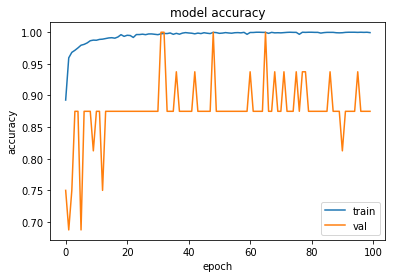

In [251]:
import matplotlib.pyplot as plt
%matplotlib inline

print(predict.history.keys())
plt.plot(predict.history['acc'])
plt.plot(predict.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [252]:
#load best trained weights

model.load_weights('model.weights.best.hdf5')

In [253]:
# print model accuracy on the test data set

score = model.evaluate(test_data, test_labels, verbose=1)
print('\n', 'Test accuracy:', score)


352/624 [===============>..............] - ETA: 0s
 Test accuracy: [2.3010393889985754, 0.78685897435897434]
